In [1]:
import networkx as nx
import osmnx as ox
import time
from shapely.geometry import Polygon, Point
import os, io, sys
import numpy as np
import ujson as json
import csv
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
from algorithms import mm_utils
import fiona
from functools import reduce
from scipy.optimize import linprog
from scipy.sparse import csr_matrix
import dask

# Remove this when debugging
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
ox.__version__

#if not os.path.exists("temp/"):
#    os.makedirs("temp/")



'1.4.0'

<Axes: >

<Axes: >

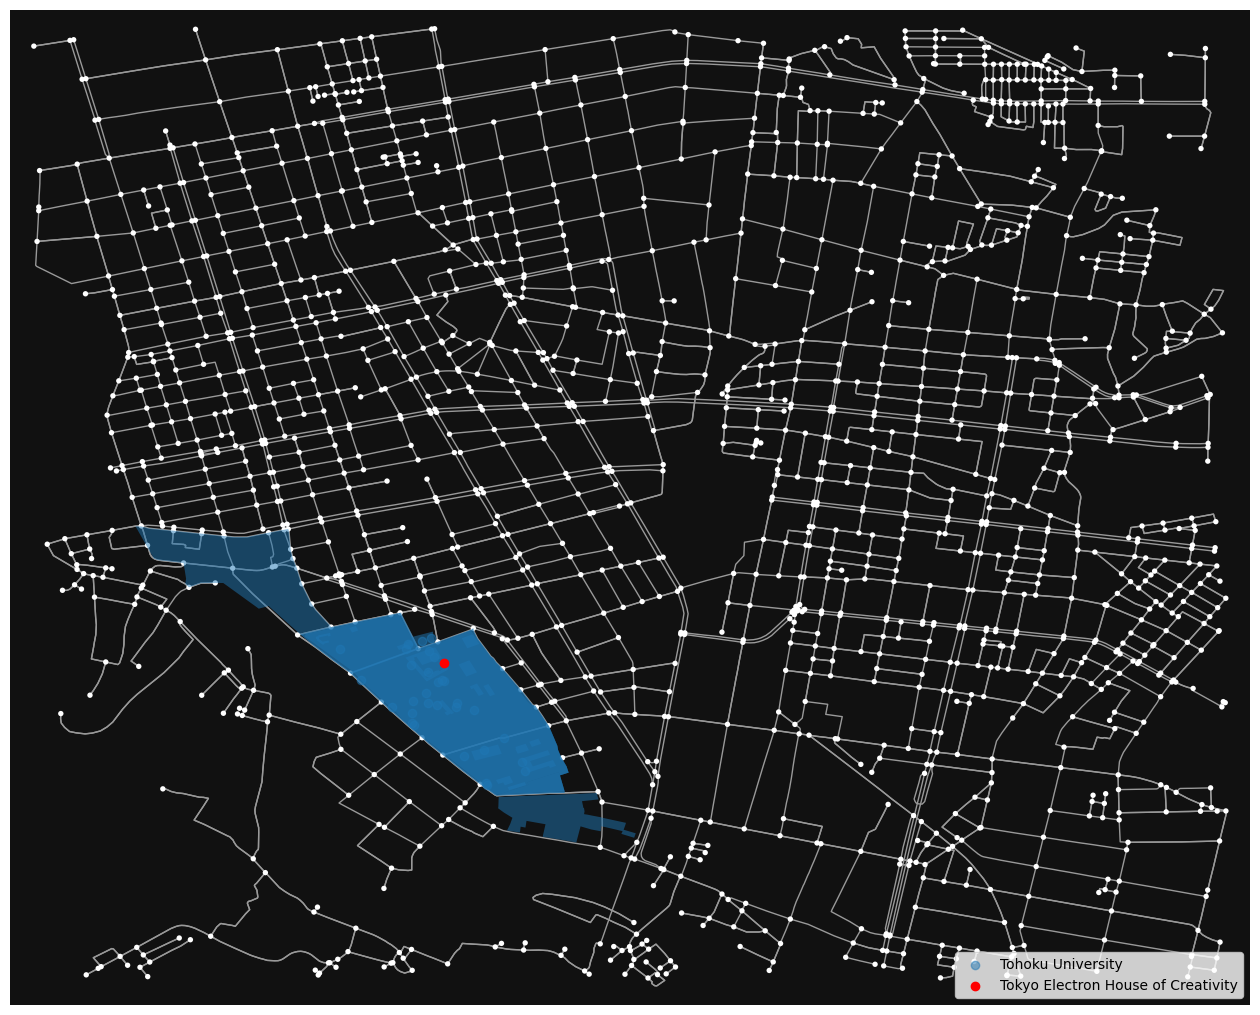

In [2]:
bignetwork = ox.graph_from_address(
"Sendai, Minamimachi-dori, Chuo 3-chome, Aoba Ward, Sendai, Miyagi Prefecture, 980-0021, Japan",
dist=1750, network_type='drive')

fig, ax = ox.plot_graph(bignetwork, figsize = (16,16),show=False,close=False)

campus = ox.geometries.geometries_from_place('Katahira Campus ',tags = {'name':True})
campus.plot(ax=ax, alpha=0.5)

gpd.GeoSeries([Point((140.87387,38.25448))]).plot(ax=ax, color='red')

ax.legend(handles=[ax.collections[4],ax.collections[5]],
          labels=['Tohoku University', 'Tokyo Electron House of Creativity'],
          loc = 'lower right')

In [3]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(bignetwork)
#gdf_edges.dtypes
gdf_edges = gdf_edges.reset_index([0,1,2])
gdf_edges = gdf_edges.set_index('osmid')


In [4]:
## We have some preprocessing to do first.

# Read the gpx directly
tripdata_nodes = gpd.read_file('Data/7-15-2022.gpx', layer = 'track_points')
    
# Read the IMU data directly
with open('Data/imu7-15-22 2_16_02.csv', mode = 'r') as f:
    tripdata_imu = csv.reader(f)
    tripdata_imu = pd.DataFrame(tripdata_imu)

# First we clean up the tripdata
tripdata_nodes = tripdata_nodes.dropna(axis=1, how = 'all')

# Let's convert the time into UNIX timestamps

from datetime import datetime as dt
import time

tripdata_nodes['time'] = (pd.to_datetime(tripdata_nodes['time']) - pd.Timestamp("1970-01-01").tz_localize("UTC")) // pd.Timedelta("1s")
tripdata_nodes = tripdata_nodes.rename(columns = {'time':'timestamp'})
tripdata_nodes = tripdata_nodes[['ele', 'timestamp', 'sat', 'geometry']]

# We will need the edges for FMM, so I wrote a helper function to create edges from points
tripdata_edges = mm_utils.point_to_traj(tripdata_nodes, columns = {'ele': 'average',
                                                                  'timestamp':'first',
                                                                  'sat':'first'})

# Now lets work on the IMU data.

tripdata_imu[0] = tripdata_imu[0].astype(float)

accel = []
for i in range(len(tripdata_imu)):
    row = tripdata_imu[[2,3,4]].loc[0]
    accel.append((float(tripdata_imu[[2,3,4]].loc[i].iloc[0]),
                  float(tripdata_imu[[2,3,4]].loc[i].iloc[1]),
                  float(tripdata_imu[[2,3,4]].loc[i].iloc[2])))

    
#tripdata_imu = tripdata_imu.rename(columns = {'0':'timestamp', '})

# We need to convert the times to UNIX timestamps.
    
timediff = dt.strptime('2022-07-15T02:16:02', '%Y-%m-%dT%H:%M:%S').timestamp() - float(tripdata_imu[0][0])

# Not going to overwrite tripdata_imu yet because we haven't done gyro yet
newdf = pd.DataFrame({'timestamp': tripdata_imu[0] + timediff, 'accelerometer' : accel,})

# We will separate the gyroscope data for later because it isn't synchronous with the rest of the data
# We will simply fuse this at the end

gyro = []
gyrotime = []

for i in range(len(tripdata_imu)):
    if tripdata_imu[5].loc[i] is not None:
        if float(tripdata_imu[5].loc[i]) == 4:
            gyrotime.append(float(newdf['timestamp'].loc[i]))
            gyro.append((float(tripdata_imu[[6,7,8]].loc[i].iloc[0]),
                      float(tripdata_imu[[6,7,8]].loc[i].iloc[1]),
                      float(tripdata_imu[[6,7,8]].loc[i].iloc[2])))

tripdata_gyro = pd.DataFrame({'timestamp':gyrotime, 'gyroscope':gyro})

tripdata_imu = newdf


In [5]:
tripdata_nodes = mm_utils.fuse(mm_utils.fuse(tripdata_nodes, tripdata_imu, 'timestamp', 'nearest neighbor'), tripdata_gyro, 'timestamp', 'nearest neighbor')

In [6]:
%%time

#from algorithms import fmm_bin
#from fmm import FastMapMatchConfig
from algorithms import metric_mm

### Define map matching configurations

k = 16
radius = 0.003
gps_error = 0.0005

# create a text trap and redirect stdout
#text_trap = io.StringIO()
#sys.stdout = text_trap

#fmm_config = FastMapMatchConfig(k,radius,gps_error)
cfg_file = None

#fmm_sim.run(tripdata_edges)


## Least squares functions
ls_ri = lambda distarray: np.square(distarray) # The function applied directly to the distances from the candidate route to the k-NN GPS coords
ls_ro = lambda distarray: 1*(1/np.size(distarray) * np.sum(distarray)) # This is where we 'integrate' over the distances, and if we need to do anything else, we do it
ls_gi = lambda distarray: np.square(distarray) # The function applied directly to the distances from the GPS coords to the k-NN candidate route nodes
ls_go = lambda distarray: 1*(1/np.size(distarray) * np.sum(distarray))
##

## Inverse squares function ('Electrical method')
eps = 0.0000001
is_ri = lambda distarray: np.power(np.square(distarray) + eps, -1) # We need eps to prevent singularities, i.e. r = 0
is_ro = lambda distarray: -1*(1/np.size(distarray) * np.sum(distarray)) # We sum, and then multiply by -1 to turn the minimizing process into a maximizing process
is_gi = lambda distarray: np.power(np.square(distarray) + eps, -1)
is_go = lambda distarray: -1*(1/np.size(distarray) * np.sum(distarray))
##

def wrapper_f(ri, ro, gi, go): # This should return a function composed from the basic functions, that can then be applied onto route and gps data.
    return lambda route, gps : 1*ro(ri(route)) + 1*go(gi(gps))

ls_loss_function = wrapper_f(ls_ri, ls_ro, ls_gi, ls_go)
is_loss_function = wrapper_f(is_ri, is_ro, is_gi, is_go)

def wasserstein(routeloss, gpsloss):#gpsloss,n,m
    #the (i,j)th entry of the gpsloss matrix is the distance from the ith point of the trajectory to the jth point on the candiate route
    # n is the number of points along the trajectory
    # m is the number of points on the candidate route
    #print(gpsloss.shape)
    n = gpsloss.shape[0]
    m = gpsloss.shape[1]
    #the (i,j)th entry of the gpsloss matrix is the distance from the ith point of the trajectory to the jth point on the candiate route
    #Create equality constraints
    b = [1/n for i in range(0,n)]+ [1/m for i in range(0,m)]
#     A = np.zeros((n+m,n*m))
#     for i in range (0,n):
#         A[i][i*m:(i+1)*m] = np.ones(m)
#     for j in range (0,m):
#         for k in range (0,n):
#             A[n+j][j+m*k] = 1
    row1 = [i for i in range(0,n) for j in range(0,m)]
    row2 = [n+j for j in range (0,m) for i in range(0,n)]
    row = np.append(np.matrix.flatten(np.array(row1)),np.matrix.flatten(np.array(row2)))
    col1 = [list(range(0,n*m))]
    col2 =  [j+m*k for j in range(0,m) for k in range(0,n)]
    col = np.append(np.matrix.flatten(np.array(col1)),np.matrix.flatten(np.array(col2)))
    data = np.ones(n*m*2)
    A = csr_matrix((data, (row, col)),shape = (n+m, n*m)).toarray()
    A = A[:-1]
    b = b[:-1]
    #solve the linear program
    res = linprog(np.matrix.flatten(gpsloss),None, None,A,b)
    #return the function value, i.e. the wasserstein distance
    loss = res.fun
    return loss


sim1 = metric_mm.Sim(ls_ri, ls_ro, ls_gi, ls_go, wrapper_f) # Least squares metric-based
sim2 = metric_mm.Sim(loss_function = is_loss_function)
sim3 = metric_mm.Sim(loss_function = wasserstein)



# now restore stdout function
#sys.stdout = sys.__stdout__

CPU times: user 3.83 ms, sys: 148 µs, total: 3.97 ms
Wall time: 3.21 ms


In [109]:
## Preprocessing Computation Times
ks = [16,32,64,128]
ns = [24, 48, 96, 192]

pp_runtime = []
kncandidate_routes = []

def candidate_generator(k,n):
    qry_pts = [x.coords[:][0] for x in gdf_edges['geometry']]           
    source_index, _ = mm_utils.get_nearest([(tripdata_nodes['geometry'].iloc[0].x, tripdata_nodes['geometry'].iloc[0].y)], qry_pts, k_neighbors = 1)
    source_index = source_index[0][0]
    target_index, _ = mm_utils.get_nearest([(tripdata_nodes['geometry'].iloc[-1].x, tripdata_nodes['geometry'].iloc[-1].y)], qry_pts, k_neighbors = 1)
    target_index = target_index[0][0]

    source = Point(qry_pts[source_index])
    target = Point(qry_pts[target_index])

    candidates = mm_utils.get_nearest_edges(tripdata_nodes, gdf_edges, k_neighbors=k, r = 0.02) # If r is too large it will run slow, as getting nearest edges is computationally difficult
    # I recommend starting with small values that yield less than k k_neighbors, and slowly increase from there
    all_candidate_edges = reduce(lambda left,right: pd.concat([left, right]).drop_duplicates(subset=['geometry']), candidates)
    
    candidate_routes = mm_utils.dijkstra(source, target, all_candidate_edges, n = n, one_way = False)
    return len(all_candidate_edges), len(candidate_routes[0]), candidate_routes


for k in ks:
    for n in ns:
        tempres = []
        temptime = %timeit -n1 -r1 -o tempres.append(candidate_generator(k,n))
        kncandidate_routes.append(tempres[0][2])
        pp_runtime.append([tempres[0][0], tempres[0][1], temptime])

52.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
49.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
50.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
55 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
53.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
57.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1min 10s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2min 19s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3min 23s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
7min 39s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
16min 53s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
40min 40s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1h 28min ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2h 57min 58s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3h 48min 2s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
21h 53min 50s ±

Text(0.5, 0, 'Number of candidate edges')

Text(0, 0.5, '$log_{10}($Runtime$)$ (seconds)')

Text(0.5, 0, 'Number of complete routes computed')

Text(0, 0.5, 'Runtime (seconds)')

Text(0.5, 0.98, 'Preprocessing (Dijkstra) Runtime')

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

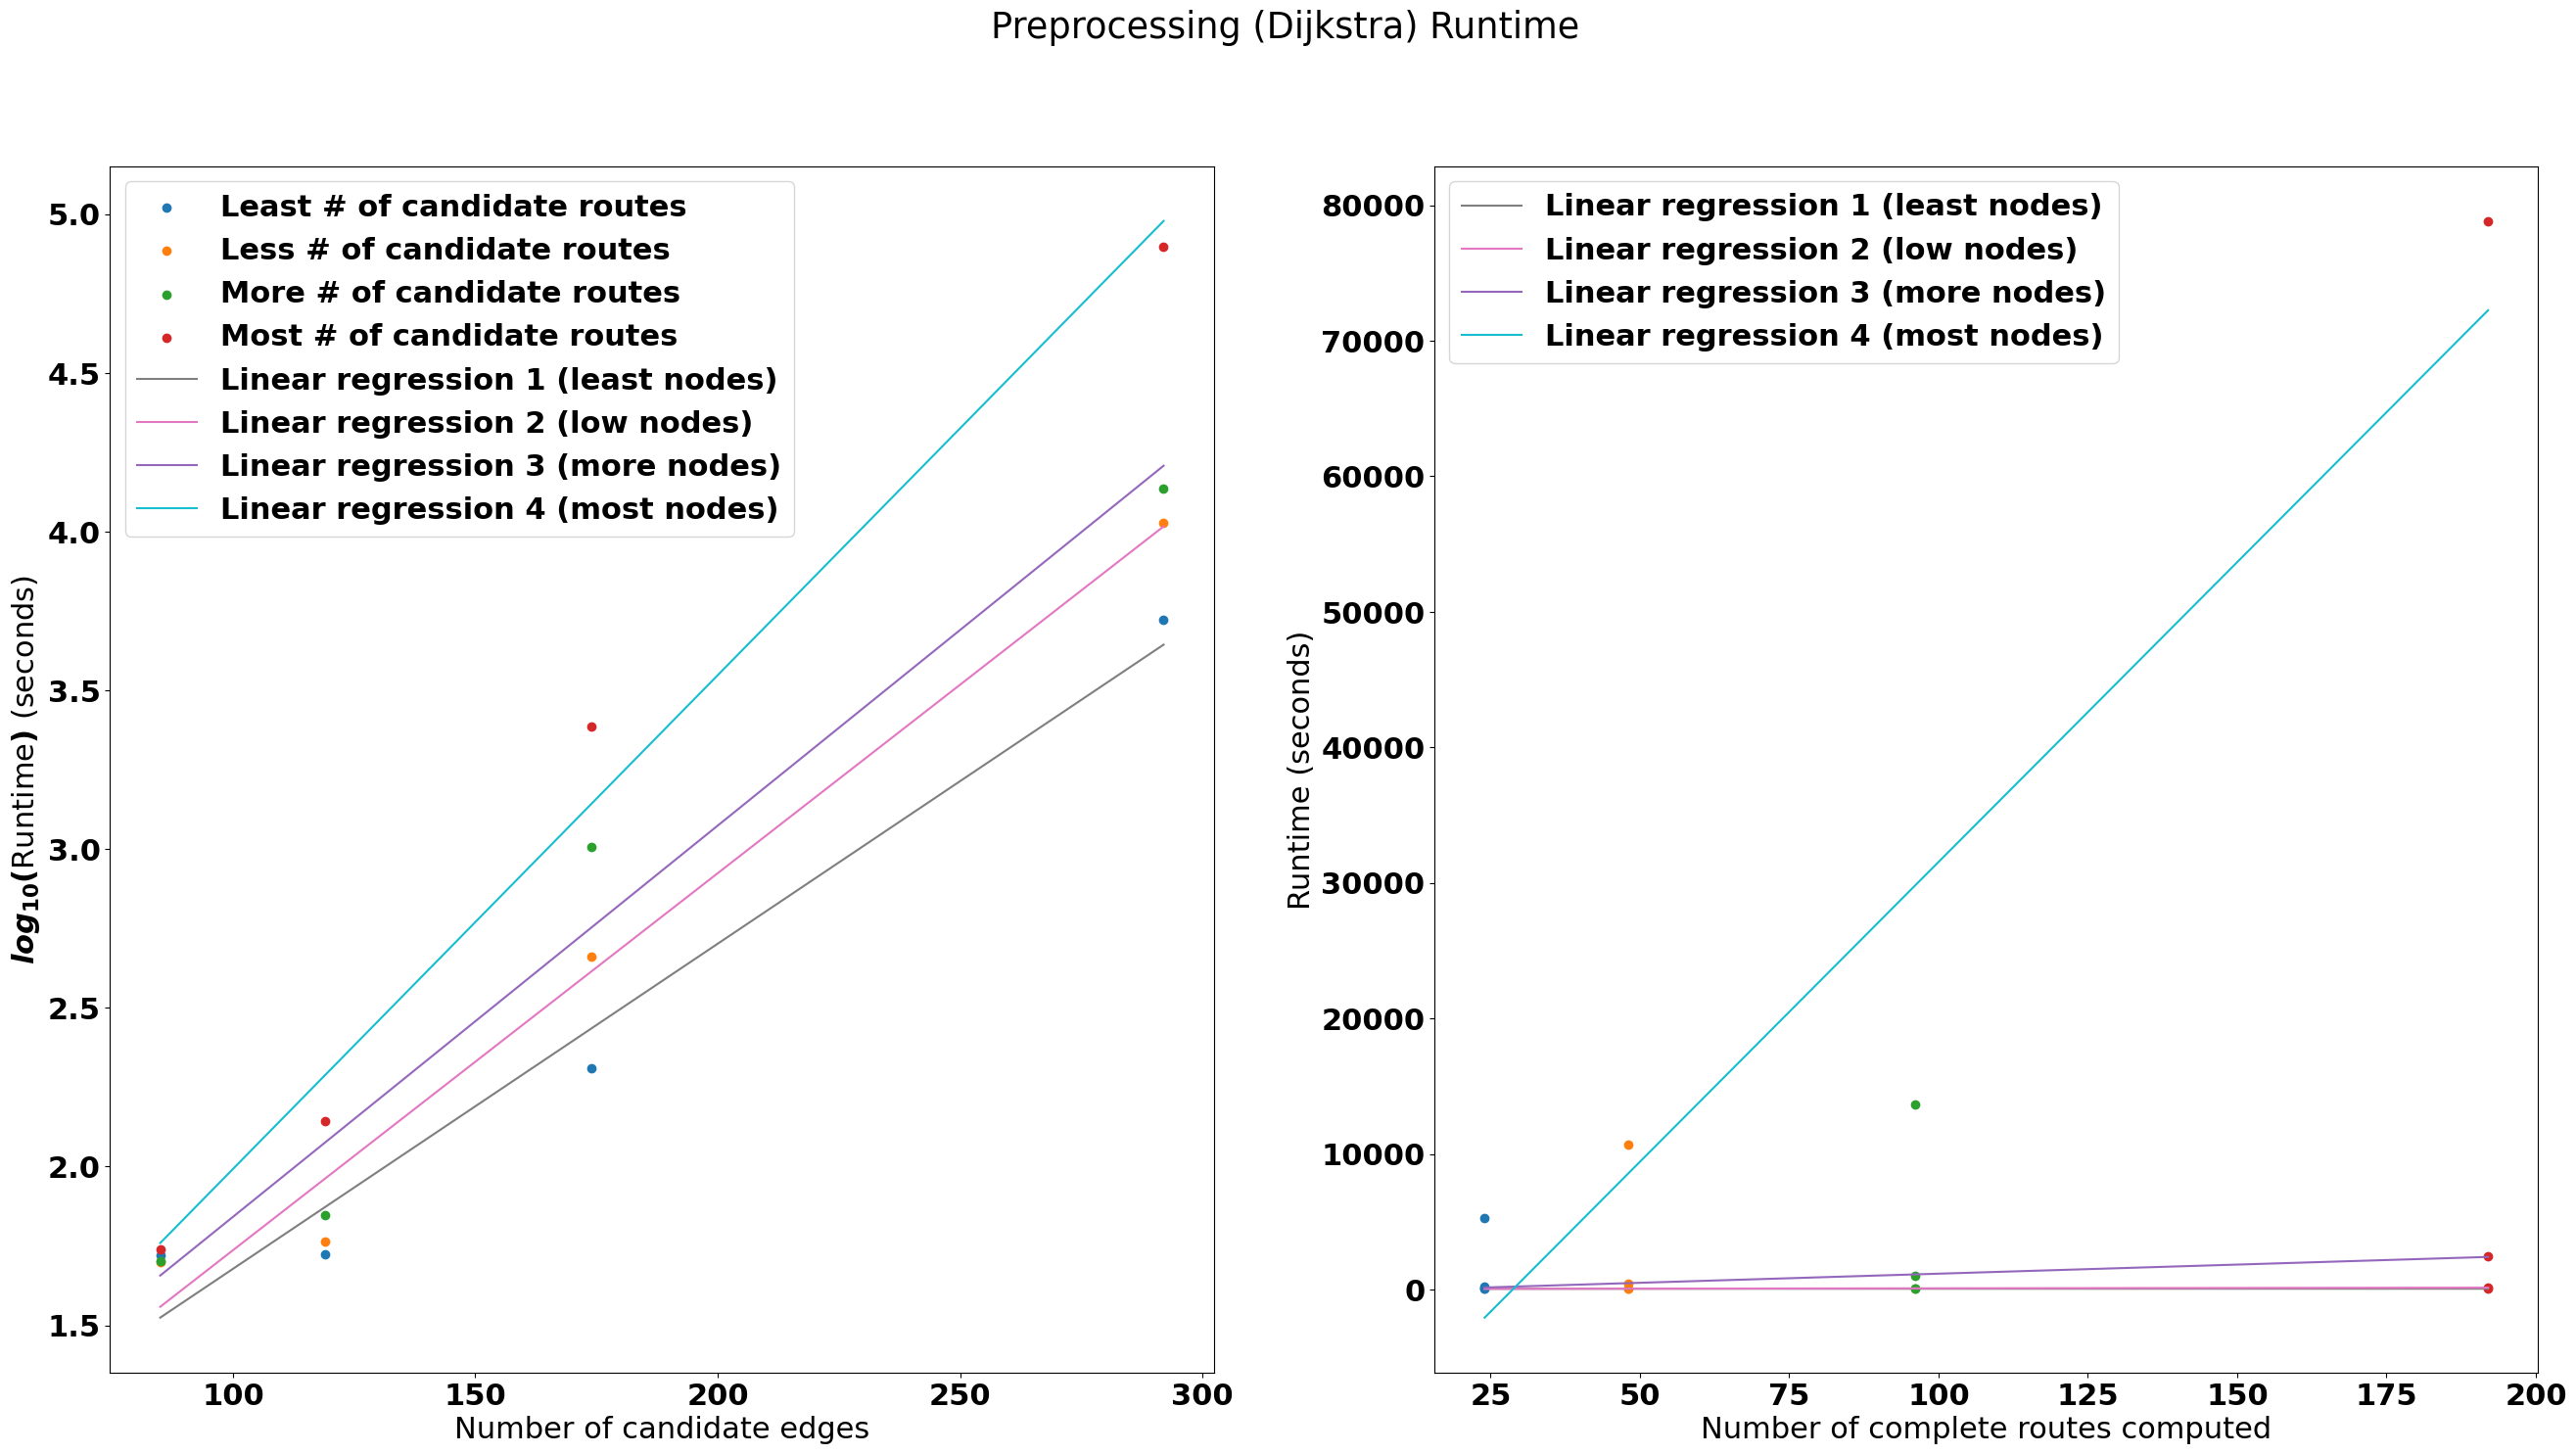

In [113]:
runtimes = np.array(pp_runtime)
runtimes[:,2] = np.array(list(map(lambda x: np.average(x.all_runs),np.array(runtimes)[:,2])))
runtimes = runtimes.astype(float)


reg1 = []
reg2 = []

for i in range(4):
    reg1.append(np.polynomial.polynomial.Polynomial.fit(runtimes[::4,0], np.log10(runtimes[i::4,2]), 1, full=True))
    reg2.append(np.polynomial.polynomial.Polynomial.fit(runtimes[0:4,1], runtimes[4*i:4*i+4,2], 1, full=True))
    
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)
    
fig, axs = plt.subplots(1,2, figsize = (32,16))
labels1 = ['Least # of candidate routes', 'Less # of candidate routes', 'More # of candidate routes', 'Most # of candidate routes']
def_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
 '#7f7f7f', '#bcbd22', '#17becf']


for i in range(4):
    axs[0].scatter(runtimes[::4,0], np.log10(runtimes[i::4,2]), label = labels1[i])
axs[0].set_xlabel('Number of candidate edges')
axs[0].set_ylabel('$log_{10}($Runtime$)$ (seconds)')
axs[0].plot(runtimes[::4,0], (reg1[0][0].convert().coef[0] + reg1[0][0].convert().coef[1]*runtimes[::4,0]), color = plt.rcParams['axes.prop_cycle'].by_key()['color'][7], label = 'Linear regression 1 (least nodes)')
axs[0].plot(runtimes[::4,0], (reg1[1][0].convert().coef[0] + reg1[1][0].convert().coef[1]*runtimes[::4,0]), color = plt.rcParams['axes.prop_cycle'].by_key()['color'][6], label = 'Linear regression 2 (low nodes)')
axs[0].plot(runtimes[::4,0], (reg1[2][0].convert().coef[0] + reg1[2][0].convert().coef[1]*runtimes[::4,0]), color = plt.rcParams['axes.prop_cycle'].by_key()['color'][4], label = 'Linear regression 3 (more nodes)')
axs[0].plot(runtimes[::4,0], (reg1[3][0].convert().coef[0] + reg1[3][0].convert().coef[1]*runtimes[::4,0]), color = plt.rcParams['axes.prop_cycle'].by_key()['color'][9], label = 'Linear regression 4 (most nodes)')
#axs[0].semilogy()
for i in range(4):
    for j in range(4): # Have to do this to make the colors right
        axs[1].scatter(runtimes[j,1], runtimes[4*i+j,2], color = def_colors[j])
axs[1].set_xlabel('Number of complete routes computed')
axs[1].set_ylabel('Runtime (seconds)')
axs[1].plot(runtimes[:4,1], (reg2[0][0].convert().coef[0] + reg2[0][0].convert().coef[1]*runtimes[:4,1]), color = plt.rcParams['axes.prop_cycle'].by_key()['color'][7], label = 'Linear regression 1 (least nodes)')
axs[1].plot(runtimes[:4,1], (reg2[1][0].convert().coef[0] + reg2[1][0].convert().coef[1]*runtimes[:4,1]), color = plt.rcParams['axes.prop_cycle'].by_key()['color'][6], label = 'Linear regression 2 (low nodes)')
axs[1].plot(runtimes[:4,1], (reg2[2][0].convert().coef[0] + reg2[2][0].convert().coef[1]*runtimes[:4,1]), color = plt.rcParams['axes.prop_cycle'].by_key()['color'][4], label = 'Linear regression 3 (more nodes)')
axs[1].plot(runtimes[:4,1], (reg2[3][0].convert().coef[0] + reg2[3][0].convert().coef[1]*runtimes[:4,1]), color = plt.rcParams['axes.prop_cycle'].by_key()['color'][9], label = 'Linear regression 4 (most nodes)')
axs[0].legend(loc = 'best')
axs[1].legend(loc = 'best')
fig.suptitle('Preprocessing (Dijkstra) Runtime')
plt.savefig("Outputs/preprocessing.png",bbox_inches='tight',dpi=100) 

In [ ]:
kns = [2, 4, 8, 16]


def sim_runner(sim, cand_rt, kn, k1 = -1, k2 = -1):
    sim.preprocessing(tripdata_edges, candidate_routes = cand_rt, n = 1, m = kn)
    sim.run(k1 = k1, k2 = k2,parallel = True)
    return 2*len(sim.candidate_route_nodes[0])*len(sim.trajectory), len(cand_rt) # The *2 comes in because we compare from BOTH directions; this is superfluous in this example, but when we do K-NN with k<n, doing K-NN for both the trajectory and the route is no longer superfluous
    

In [ ]:
sim1_runtime = []

for kn in kns:
    for cand_routes in kncandidate_routes:
        tempres = []
        temptime = %timeit -n1 -r1 -o tempres.append(sim_runner(sim1,cand_routes[0],kn))
        sim1_runtime.append([tempres[0][0], tempres[0][1], temptime])

In [ ]:
runtimes = np.array(sim1_runtime)
runtimes[:,2] = np.array(list(map(lambda x: np.average(x.all_runs),np.array(runtimes)[:,2])))
runtimes = runtimes.astype(float)


reg = []

for i in range(4):
    reg.append(np.polynomial.polynomial.Polynomial.fit(runtimes[16*i:16*i+16,1], runtimes[16*i:16*i+16,2], 1, full=True))

np.arange(0,16,1)*4
    
fig, axs = plt.subplots(1,2, figsize = (32,16))
labels = ['Least # of Candidate Routes', 'Less # of Candidate Routes', 'More # of Candidate Routes', 'Most # of Candidate Routes']
for i in range(4):
    rang = np.arange(0,16,1)*4 + i
    axs[0].scatter(runtimes[rang,0], runtimes[rang,2], label = labels[i])
axs[0].set_xlabel('Number of distance calculations in one candidate route')
axs[0].set_ylabel('Runtime (seconds)')
for i in range(4):
    rang = np.arange(0,16,1)*4 + i
    axs[1].scatter(runtimes[rang,1], runtimes[rang,2])
axs[1].set_xlabel('Number of candidate routes')
axs[1].set_ylabel('Runtime (seconds)')
axs[1].plot(runtimes[:,1], (reg[0][0].convert().coef[0] + reg[0][0].convert().coef[1]*runtimes[:,1]), color = plt.rcParams['axes.prop_cycle'].by_key()['color'][7], label = 'Linear Regression 1 (least nodes)')
axs[1].plot(runtimes[:,1], (reg[1][0].convert().coef[0] + reg[1][0].convert().coef[1]*runtimes[:,1]), color = plt.rcParams['axes.prop_cycle'].by_key()['color'][6], label = 'Linear Regression 2 (low nodes)')
axs[1].plot(runtimes[:,1], (reg[2][0].convert().coef[0] + reg[2][0].convert().coef[1]*runtimes[:,1]), color = plt.rcParams['axes.prop_cycle'].by_key()['color'][4], label = 'Linear Regression 3 (more nodes)')
axs[1].plot(runtimes[:,1], (reg[3][0].convert().coef[0] + reg[3][0].convert().coef[1]*runtimes[:,1]), color = plt.rcParams['axes.prop_cycle'].by_key()['color'][9], label = 'Linear Regression 4 (most nodes)')
axs[0].legend(loc = 'best')
axs[1].legend(loc = 'best')
fig.suptitle('Least Squares Runtime')
plt.savefig("Outputs/complexity1.png",bbox_inches='tight',dpi=100) 

In [ ]:
sim2_runtime = []

for kn in kns:
    for cand_routes in kncandidate_routes:
        tempres = []
        temptime = %timeit -n1 -r1 -o tempres.append(sim_runner(sim2,cand_routes[0],kn))
        sim2_runtime.append([tempres[0][0]/2, tempres[0][1], temptime])

In [ ]:
runtimes = np.array(sim2_runtime)
runtimes[:,2] = np.array(list(map(lambda x: np.average(x.all_runs),np.array(runtimes)[:,2])))
runtimes = runtimes.astype(float)


reg = []

for i in range(4):
    reg.append(np.polynomial.polynomial.Polynomial.fit(runtimes[16*i:16*i+16,1], runtimes[16*i:16*i+16,2], 1, full=True))

np.arange(0,16,1)*4
    
fig, axs = plt.subplots(1,2, figsize = (32,16))
labels = ['Least # of Candidate Routes', 'Less # of Candidate Routes', 'More # of Candidate Routes', 'Most # of Candidate Routes']
for i in range(4):
    rang = np.arange(0,16,1)*4 + i
    axs[0].scatter(runtimes[rang,0], runtimes[rang,2], label = labels[i])
axs[0].set_xlabel('Number of distance calculations in one candidate route')
axs[0].set_ylabel('Runtime (seconds)')
for i in range(4):
    rang = np.arange(0,16,1)*4 + i
    axs[1].scatter(runtimes[rang,1], runtimes[rang,2])
axs[1].set_xlabel('Number of candidate routes')
axs[1].set_ylabel('Runtime (seconds)')
axs[1].plot(runtimes[:,1], (reg[0][0].convert().coef[0] + reg[0][0].convert().coef[1]*runtimes[:,1]), color = plt.rcParams['axes.prop_cycle'].by_key()['color'][7], label = 'Linear Regression 1 (least nodes)')
axs[1].plot(runtimes[:,1], (reg[1][0].convert().coef[0] + reg[1][0].convert().coef[1]*runtimes[:,1]), color = plt.rcParams['axes.prop_cycle'].by_key()['color'][6], label = 'Linear Regression 2 (low nodes)')
axs[1].plot(runtimes[:,1], (reg[2][0].convert().coef[0] + reg[2][0].convert().coef[1]*runtimes[:,1]), color = plt.rcParams['axes.prop_cycle'].by_key()['color'][4], label = 'Linear Regression 3 (more nodes)')
axs[1].plot(runtimes[:,1], (reg[3][0].convert().coef[0] + reg[3][0].convert().coef[1]*runtimes[:,1]), color = plt.rcParams['axes.prop_cycle'].by_key()['color'][9], label = 'Linear Regression 4 (most nodes)')
axs[0].legend(loc = 'best')
axs[1].legend(loc = 'best')
fig.suptitle('Inverse Squares Runtime')
plt.savefig("Outputs/complexity2.png",bbox_inches='tight',dpi=100) 

In [ ]:
sim3_runtime = []

for kn in kns:
    for cand_routes in kncandidate_routes:
        tempres = []
        temptime = %timeit -n1 -r1 -o tempres.append(sim_runner(sim3,cand_routes[0],int(kn/2), k1=1))
        sim3_runtime.append([tempres[0][0]/2, tempres[0][1], temptime])

In [ ]:
runtimes = np.array(sim3_runtime)
runtimes[:,2] = np.array(list(map(lambda x: np.average(x.all_runs),np.array(runtimes)[:,2])))
runtimes = runtimes.astype(float)


reg = []

for i in range(4):
    reg.append(np.polynomial.polynomial.Polynomial.fit(runtimes[16*i:16*i+16,1], runtimes[16*i:16*i+16,2], 1, full=True))

np.arange(0,16,1)*4
    
fig, axs = plt.subplots(1,2, figsize = (16,8))
labels = ['Least # of Candidate Routes', 'Less # of Candidate Routes', 'More # of Candidate Routes', 'Most # of Candidate Routes']
for i in range(4):
    rang = np.arange(0,16,1)*4 + i
    axs[0].scatter(runtimes[rang,0], runtimes[rang,2], label = labels[i])
axs[0].set_xlabel('Number of distance calculations in one candidate route')
axs[0].set_ylabel('Runtime (seconds)')
for i in range(4):
    rang = np.arange(0,16,1)*4 + i
    axs[1].scatter(runtimes[rang,1], runtimes[rang,2])
axs[1].set_xlabel('Number of candidate routes')
axs[1].set_ylabel('Runtime (seconds)')
axs[1].plot(runtimes[:,1], (reg[0][0].convert().coef[0] + reg[0][0].convert().coef[1]*runtimes[:,1]), color = plt.rcParams['axes.prop_cycle'].by_key()['color'][7], label = 'Linear Regression 1 (least nodes)')
axs[1].plot(runtimes[:,1], (reg[1][0].convert().coef[0] + reg[1][0].convert().coef[1]*runtimes[:,1]), color = plt.rcParams['axes.prop_cycle'].by_key()['color'][6], label = 'Linear Regression 2 (low nodes)')
axs[1].plot(runtimes[:,1], (reg[2][0].convert().coef[0] + reg[2][0].convert().coef[1]*runtimes[:,1]), color = plt.rcParams['axes.prop_cycle'].by_key()['color'][4], label = 'Linear Regression 3 (more nodes)')
axs[1].plot(runtimes[:,1], (reg[3][0].convert().coef[0] + reg[3][0].convert().coef[1]*runtimes[:,1]), color = plt.rcParams['axes.prop_cycle'].by_key()['color'][9], label = 'Linear Regression 4 (most nodes)')
axs[0].legend(loc = 'best')
axs[1].legend(loc = 'best')
fig.suptitle('Wasserstein Squares Runtime')
plt.savefig("Outputs/complexity3.png",bbox_inches='tight',dpi=100) 